# MÓDULO 4: LA CIENCIA DE DATOS Y LOS MODELOS DE ANALÍTICA PREDICTIVA EN LA INDUSTRIA 4.0

## 12- Métodos probabilísticos y optimización heurística
### Bayesian inference and learning: Bayesian networks

# The student network

En este notebook vamos a tratar los siguientes puntos:
* Cómo representar las variables de una red bayesiana de manera 'manual' (formato de tipo hashmap, diccionario o json)
* Pintar la red bayesiana resultante, grafo y probabilidades asociadas, mediante Graphviz
* Compilar la red bayesiana y jugar un poco con ella

Referencias:
- https://github.com/pgmpy/
- Daphne Koller, Nir Friedman. Probabilistic Graphical Models, Principles and Techniques, 2009, page 53

## Configuración de la red

### Nodos del grafo y relaciones entre ellos

Cada pareja de la lista define 2 nodos y el enlace entre ellos. En 'graphviz_helper.py' la lista se renderiza en forma de grafo y las relaciones entre los nodos

### Variables

El parámetro 'variables' describe cada nodo dentro del grafo. Para cada nodo, identificado con una letra, tenemos la descripción del nodo o variable ('desc' o nombre completo), la leyenda ('legend', con los valores posibles que toma la variable) y las probabilidades para cada valor ('cpd', o *Conditional Probability Distribution*, incluyendo también la interacción con otros nodos)   

In [4]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [5]:
structures = [('D', 'G'), ('I', 'G'), ('G', 'L'), ('I', 'S')]

variables = {
    'D': {
        'desc': "Difficulty",
        'legend': {0: 'Easy', 1: 'Hard'},
        'cpd': { 0: 0.4, 1: 0.6}
    },
    'I': {
        'desc': "Intelligence",
        'legend': {0: 'Dumb', 1: 'Intelligent'},
        'cpd': { 0: 0.7, 1: 0.3 }
    },
    'G': {
        'desc': "Grade",
        'legend': { 0:'A', 1:'B', 2:'C' },
        'cpd': {
            0: { 'I': { 0: { 'D': { 0: 0.3, 1: 0.05 } },
                        1: { 'D': { 0: 0.9, 1: 0.5 } } } },
            1: { 'I': { 0: { 'D': { 0: 0.4, 1: 0.25 } },
                        1: { 'D': { 0: 0.08, 1: 0.3 } } } },
            2: { 'I': { 0: { 'D': { 0: 0.3, 1: 0.7 } },
                        1: { 'D': { 0: 0.02, 1: 0.2 } } } },
        }
    },
    'L': {
        'desc': "Letter",
        'legend': { 0:'Bad', 1:'Good' },
        'cpd': {
            0: { 'G': { 0: 0.1, 1: 0.4, 2: 0.99 } },
            1: { 'G': { 0: 0.9, 1: 0.6, 2: 0.01 } }
        }
    },
    'S':{
        'desc': "SAT",
        'legend': { 0:'Bad', 1:'Good' },
        'cpd': {
            0: { 'I': { 0: 0.95, 1: 0.2 } },
            1: { 'I': { 0: 0.05, 1: 0.8} }
        }
    }
}

Representamos gráficamente la red bayesiana resultante

In [6]:
%load_ext autoreload
%autoreload 2

from graphviz_helper import render_graph
from graphviz_helper import render_graph_probabilities

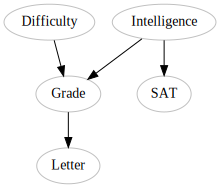

In [7]:
g = render_graph(structures, variables)
g

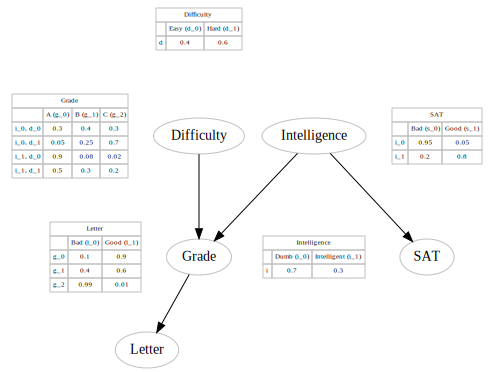

In [8]:
g = render_graph_probabilities(g, variables)
g

Construimos la red bayesiana con pgmpy para ejecutar queries a través del modelo resultante

In [9]:
from graphviz_helper import build_BayesianModel

# Defining the model structure. We can define the network by just passing a list of edges.
model = build_BayesianModel(structures, variables)

model.check_model()

adding cpd_d
adding cpd_i
adding cpd_g
adding cpd_l
adding cpd_s


True

In [10]:
model.get_cpds()

[<TabularCPD representing P(D:2) at 0x7fb47c061128>,
 <TabularCPD representing P(I:2) at 0x7fb47c0611d0>,
 <TabularCPD representing P(G:3 | I:2, D:2) at 0x7fb3eca13d68>,
 <TabularCPD representing P(L:2 | G:3) at 0x7fb46c0d1cf8>,
 <TabularCPD representing P(S:2 | I:2) at 0x7fb3fb838588>]

Vamos a echar un vistazo a la CPD para un nodo. pgmpy nos permite ver las probabilidades asociadas a una variable. Chequeamos el nodo 'G' ('grade'), por ejemplo

In [11]:
print(model.get_cpds('G'))

+------+------+------+------+------+
| I    | I(0) | I(0) | I(1) | I(1) |
+------+------+------+------+------+
| D    | D(0) | D(1) | D(0) | D(1) |
+------+------+------+------+------+
| G(0) | 0.3  | 0.05 | 0.9  | 0.5  |
+------+------+------+------+------+
| G(1) | 0.4  | 0.25 | 0.08 | 0.3  |
+------+------+------+------+------+
| G(2) | 0.3  | 0.7  | 0.02 | 0.2  |
+------+------+------+------+------+


Podemos mostrar también las independencias locales en la red bayesiana

In [12]:
# Getting all the local independencies in the network.
model.local_independencies(['D', 'I', 'S', 'G', 'L'])

(D _|_ S, I)
(I _|_ D)
(S _|_ G, D, L | I)
(G _|_ S | D, I)
(L _|_ S, D, I | G)

Y chequear si, dadas dos variables A y B, un cambio en A tiene algún efecto en los valores de B ('active_trail' entre A y B). En nuestro caso, por ejemplo, vemos qué nodos se verían afectados por un cambio en 'G'

In [13]:
# Active trail: For any two variables A and B in a network if any change in A influences the values of B then we say
#               that there is an active trail between A and B.
# In pgmpy active_trail_nodes gives a set of nodes which are affected by any change in the node passed in the argument.
model.active_trail_nodes('G')

{'G': {'D', 'G', 'I', 'L', 'S'}}

Para hacer inferencia sobre el modelo aplicamos el método 'VariableElimination'

In [14]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

Vamos ahora a hacer inferencia sobre la variable 'G' dado que el exámen es difícil, 'd_1', mostrando la tabla CPD resultante con las probabilidades a posteriori de cada posible nota

In [15]:
print(infer.query(['G'], evidence={'D':1}))

Eliminating: I: 100%|██████████| 3/3 [00:00<00:00, 910.35it/s]

+------+----------+
| G    |   phi(G) |
+======+==========+
| G(0) |   0.1850 |
+------+----------+
| G(1) |   0.2650 |
+------+----------+
| G(2) |   0.5500 |
+------+----------+


## EJERCICIO

Si el exámen no fue muy difícil ('d_0') y asumimos que el estudiante es inteligente ('i_1'):

* 1: Cuál es la probabilidad de que un estudiante consiga un grado 'A' ('g_0')?
* 2: Cuál es la probabilidad de que un estudiante consiga una letra de recomendación ('l_1')?
* 3: Cuál es la probabilidad de que un estudiante consiga una puntuación SAT ('s')?

In [16]:
...

Ellipsis

Vamos también a predecir valores de las variables sin tener en cuenta las probabilidades, únicamente queremos saber el valor de salida de la variable. Es muy similar al hecho de computar las probabilidades condicionales. Necesitamos consultar la variable a predecir dados los valores de las otras variables. Lo que se conoce en pgmpy como *MAP query*

Por ejemplo, para la variable 'G' sin ninguna evidencia previa o valor de otra variable, podemos chequear el valor de grado o nota más probable  

In [17]:
print(infer.map_query(['G']))

Eliminating: I: 100%|██████████| 4/4 [00:00<00:00, 888.58it/s]

{'G': 2}


## EJERCICIO

Dadas las evidencias del ejercicio anterior, el exámen no fue muy difícil ('d_0') y asumimos que el estudiante es inteligente ('i_1'):

* 1: Cuál es la nota más probable, 'G'?
* 2: Conseguirá el estudiante una carta de recomendación, 'L'?
* 3: Conseguirá el estudiante una puntuación SAT?

In [18]:
...

Ellipsis